In [22]:
import tensorflow as tf
import numpy as np
import pandas as pd , sys
import matplotlib.pyplot as plt
import scikitplot as skplt
from IPython.display import clear_output
from sklearn.metrics import auc , roc_auc_score
sys.path.append("/home/advice/Python/SR/Custom/")
from RAdam import RAdamOptimizer
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [23]:
from tensorflow.contrib.layers import *
def get_weight_variable(shape, name=None,
                        type='xavier_uniform', regularize=True, **kwargs):
    initialise_from_constant = False
    if type == 'xavier_uniform':
        initial = xavier_initializer(uniform=True, dtype=tf.float32)
    elif type == 'xavier_normal':
        initial = xavier_initializer(uniform=False, dtype=tf.float32)
    elif type == 'he_normal':
        initial = variance_scaling_initializer(uniform=False, factor=2.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'he_uniform':
        initial = variance_scaling_initializer(uniform=True, factor=2.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'caffe_uniform':
        initial = variance_scaling_initializer(uniform=True, factor=1.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'simple':
        stddev = kwargs.get('stddev', 0.02)
        initial = tf.truncated_normal(shape, stddev=stddev, dtype=tf.float32)
        initialise_from_constant = True
    elif type == 'bilinear':
        weights = _bilinear_upsample_weights(shape)
        initial = tf.constant(weights, shape=shape, dtype=tf.float32)
        initialise_from_constant = True
    else:
        raise ValueError('Unknown initialisation requested: %s' % type)

    if name is None:  # This keeps to option open to use unnamed Variables
        weight = tf.Variable(initial)
    else:
        if initialise_from_constant:
            weight = tf.get_variable(name, initializer=initial)
        else:
            weight = tf.get_variable(name, shape=shape, initializer=initial)

    if regularize:
        tf.add_to_collection('weight_variables', weight)
    return weight 

In [24]:
data = pd.read_csv("./../Data/DontOverfit/train.csv")
test_data = pd.read_csv("./../Data/DontOverfit/test.csv")
__id__ = data.pop("id")

In [25]:
target_yy = data.pop("target")
target_y = target_yy.values.reshape(-1,1)

In [26]:
target_yy.value_counts(normalize = True )

0.0    0.732
1.0    0.268
Name: target, dtype: float64

In [27]:
data.shape

(250, 300)

In [28]:
target_1_list = target_yy[(target_yy == 1) == True].index.tolist()
target_0_list = target_yy[(target_yy == 0) == True].index.tolist()

In [29]:
print(target_1_list)

[0, 3, 6, 17, 19, 25, 27, 28, 30, 31, 32, 34, 36, 44, 53, 54, 57, 59, 66, 68, 70, 74, 86, 88, 90, 91, 99, 100, 103, 109, 115, 117, 122, 123, 130, 138, 145, 146, 149, 154, 156, 158, 164, 166, 169, 179, 185, 187, 188, 193, 195, 196, 197, 198, 200, 203, 204, 209, 213, 218, 220, 229, 230, 232, 242, 245, 248]


In [30]:
print(target_0_list)

[1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 21, 22, 23, 24, 26, 29, 33, 35, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 55, 56, 58, 60, 61, 62, 63, 64, 65, 67, 69, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 89, 92, 93, 94, 95, 96, 97, 98, 101, 102, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 116, 118, 119, 120, 121, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 147, 148, 150, 151, 152, 153, 155, 157, 159, 160, 161, 162, 163, 165, 167, 168, 170, 171, 172, 173, 174, 175, 176, 177, 178, 180, 181, 182, 183, 184, 186, 189, 190, 191, 192, 194, 199, 201, 202, 205, 206, 207, 208, 210, 211, 212, 214, 215, 216, 217, 219, 221, 222, 223, 224, 225, 226, 227, 228, 231, 233, 234, 235, 236, 237, 238, 239, 240, 241, 243, 244, 246, 247, 249]


## 앙상블 테스트

In [31]:
select = ['243', '29', '35', '299', '219', '32', '59', '133', '150', '127', '103', '199', '78', '77', '74', '23', '267', '264', '14', '152', '177', '54', '215', '93', '52', '162', '176', '76', '220', '159', '297', '94', '185', '140', '115', '108', '95', '198', '34', '130', '137', '240', '18', '49', '141', '260', '17', '50', '161', '104', '57', '63', '214', '56', '62', '201', '53', '48', '80', '277', '247', '261', '258', '287', '119', '284', '12', '100', '135', '33', '273', '167', '225', '279', '216', '292', '75', '69', '268', '276', '90', '223', '106', '281', '92', '112', '3', '128', '111', '20', '250', '192', '269', '60', '190', '84', '205', '251', '91', '270', '191', '136', '160', '182', '68', '180', '99', '290', '66', '79', '25', '11', '142', '8', '27', '193', '282', '30', '202', '7', '203', '31', '58', '253', '43', '244', '246', '126', '224', '262', '121', '172', '125', '265', '0']
#sample_dim = np.random.permutation(data.shape[1])[:200]

np_data = data.values
#[select].values
# np_data = StandardScaler().fit_transform(np_data)

In [32]:
np_data.shape

(250, 300)

In [33]:
row , dim = np_data.shape
print(row,dim)
target_n = 2 
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape = [ None , dim])
y = tf.placeholder(tf.float32, shape = [ None , 1])
DropoutRate = tf.placeholder(tf.float32, name ="dropoutRate")
training = tf.placeholder_with_default(False, shape=[], name="training")

250 300


In [34]:
# mod = sys.modules[__name__]
# for i in range(10):
#     setattr(mod, 'var_{}'.format(i), i)

In [35]:
def tf_mish(x) :
    return x * tf.nn.tanh(tf.nn.softplus(x))

activate_candidate = \
[tf.nn.selu, tf_mish , tf.nn.leaky_relu ]

In [36]:
def Classifier(X , hidden = [dim , 250,150,100,50,10 , target_n], 
               Nensemble = 3 ) :
    Ensembles = []
    with tf.variable_scope("Ensembles"):
        for N in np.arange(Nensemble) :
            SELECT = np.random.randint(0 , len(activate_candidate) , 1)[0]
            activation = activate_candidate[SELECT]
            hidden_N = hidden[N]
            for idx in np.arange(len( hidden_N )-1) : 
                hid = hidden_N[idx]
                if (idx+1) < len(hidden_N) :
                    w = (variance_scaling_initializer(uniform=False,
                                                      factor=2.0, mode='FAN_IN', dtype=tf.float32)
                         ((hid ,hidden_N[idx+1])))
                    W = tf.Variable(w, name = "Weight")
                    Bias = tf.Variable(tf.random_normal([hidden_N[idx+1]], stddev = 0.01))
                    if idx == 0 :
                        dropX = tf.nn.dropout(X , keep_prob = 0.5 , 
                                              seed = N + 1234 )
                        Layer = activation(tf.matmul(dropX , W) + Bias)
                        #Layer = tf.contrib.nn.alpha_dropout(Layer , DropoutRate ) 
                    else :
                        if target_n == hidden_N[idx+1] :
                            Layer = tf.matmul(Layer , W) + Bias
                        else :
                            Layer = tf.matmul(Layer , W) + Bias
                            Layer = tf.layers.batch_normalization(Layer,
                                                                  training= training ,
                                                                  momentum = 0.999)
                            Layer = activation(Layer)
#                             Layer = tf.contrib.nn.alpha_dropout(Layer , DropoutRate ) 
                else : pass
            Ensembles.append(Layer)
        #Input = tf.concat(Ensembles, axis=1, name='Inputs')
    return Ensembles


In [37]:
HIDDEN = [[dim , 100 , 50 , 10 ,  target_n] , 
          [dim , 80 , 25, target_n] ,
          [dim , 50 , 10, target_n]
         ]
NModels = Classifier(X , hidden = HIDDEN , Nensemble= 3)
NModels_MEAN = tf.reduce_mean(NModels , axis = 0)
Probs = tf.nn.softmax(NModels_MEAN)
y_one_hot = tf.one_hot( tf.cast(tf.squeeze(y , axis = 1 ) , tf.int32) , depth=2)

In [38]:
from sklearn.utils.class_weight import compute_class_weight
y_weight_info = compute_class_weight(class_weight= "balanced" , 
                     classes = np.unique(target_y),
                     y= np.squeeze(target_y))
weight = tf.constant([ y_weight_info[1] ] ) # 

## Version1 (Averaging)

In [41]:
WCE = tf.nn.weighted_cross_entropy_with_logits(targets = y_one_hot ,
                                               logits = NModels_MEAN , 
                                               pos_weight =  weight)
Loss = tf.reduce_mean(WCE)

## Version2 (개별)

In [40]:
Loss = 0
for Model in NModels :
    loss = tf.nn.weighted_cross_entropy_with_logits(targets = y_one_hot ,
                                                     logits = Model , 
                                                     pos_weight = weight)
    Loss += tf.reduce_mean(loss)
Loss /= len(NModels)

In [42]:
vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="Ensembles")
L2 = []
import re 
for v in vars :
    if re.search('Weight' , v.name) :
        L2.append(tf.nn.l2_loss(v))
Loss += tf.add_n(L2)  * 0.001

In [43]:
solver = RAdamOptimizer(learning_rate= 1e-4).minimize(Loss ,var_list = vars )

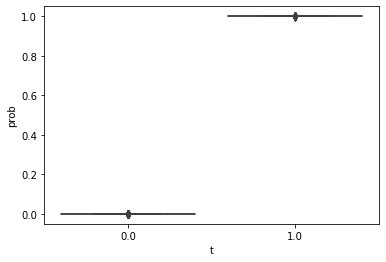

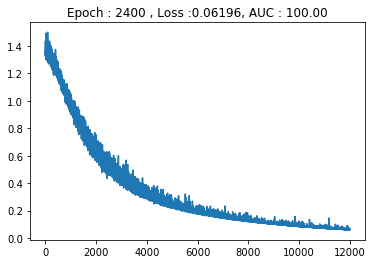

[[183   0]
 [  0  67]]
Epoch : 2500 , Loss :0.05768, AUC : 100.00


KeyboardInterrupt: 

In [51]:
from sklearn.metrics import confusion_matrix
Epoch = 10000
mb_size = 50
config=tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)
sess.run(tf.global_variables_initializer())
_Loss_ = []
print("Train")
for epoch in range(Epoch) :
    target1 = np.random.choice(target_1_list ,
                               len(target_1_list) ,
                               replace = False )
    target0 = np.random.choice(target_0_list , 
                               len(target_0_list) ,
                               replace = True )
    target1 = list(target1)
    target0 = list(target0)
    if epoch > 0 :
        target1 = target1 + checkpoint 
    XX = np_data[target1 + target0  , : ]
    YY = target_y[target1 + target0 , : ]
    idx = np.random.permutation(len(XX))
    XX = XX[idx , : ]
    YY = YY[idx , : ]
    batch_iter = int(len(XX) / mb_size)
    for idx in range(batch_iter) :
        X_mb = XX[idx*mb_size:(idx+1)*mb_size]
        Y_mb = YY[idx*mb_size:(idx+1)*mb_size]
        Feed = {X : X_mb ,
                y : Y_mb , 
                DropoutRate : 0.1 ,
                training : True 
               }
        _ , LOSS  = sess.run([solver , Loss] , feed_dict= Feed)
        _Loss_.append(LOSS)
    
    Feed = { X : np_data  ,
            DropoutRate : 1 ,
            training : True 
           }
    probs  = sess.run(Probs , feed_dict= Feed)
    AUC = roc_auc_score(np.squeeze(target_y) ,  probs[:,1])
    DD = pd.DataFrame([np.squeeze(target_y) ,
                       np.argmax(probs,axis =1)], index = ["t","p"]).T
    DD2 = DD[(DD.t == 1) & (DD.p==0)]
    checkpoint = DD2.index.tolist()
    DD = pd.DataFrame([np.squeeze(target_y) ,probs[:,1]],
                      index = ["t","prob"]).T
    if epoch % 100 == 0 :
        print( confusion_matrix(np.squeeze(target_y) , 
                                np.argmax(probs,axis =1) ))
        msg = "Epoch : {} , Loss :{:.5f}, AUC : {:.2f}".format(epoch ,
                                                                 LOSS ,
                                                                 AUC*100)
        print(msg)

    if epoch % 300 == 0 :
        clear_output()
        sns.boxplot(x="t", y="prob", data=DD)
        plt.show()
        plt.plot(np.arange(len(_Loss_)), _Loss_ )
        plt.title(msg)
        plt.show()

In [45]:
test_data.head()
__test_id__ = test_data.pop("id")
np_test = test_data.values

In [46]:
Feed = { X : np_test  ,
            DropoutRate : 1 ,
            training : True 
           }
probs  = sess.run(Probs , feed_dict= Feed)

In [47]:
submission = pd.DataFrame(__test_id__)
submission["target"] = np.argmax(probs, axis = 1)

In [49]:
submission.to_csv("dontovefit_submission2.csv", index = False)

In [50]:
submission.head()

,id,target
0,250,1
1,251,1
2,252,0
3,253,0
4,254,1


## 변수 중요도를 이용한 변수 선택 및 AutoEncoder로 파생 변수 넣어보기 

## gradient boosting 알고리즘 참고해보기..

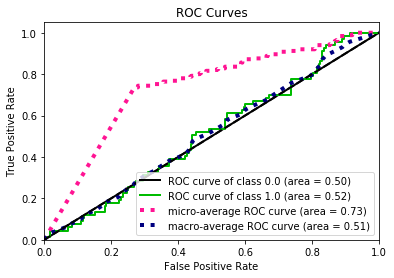

In [29]:
skplt.metrics.plot_roc(np.squeeze(target_y),
                       probs)
plt.show()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


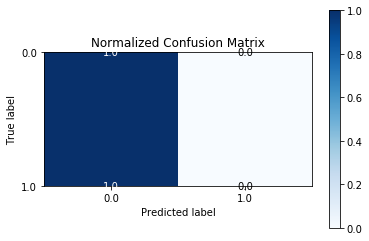

In [35]:
pred  = np.argmax(probs , axis =1 )
skplt.metrics.plot_confusion_matrix(np.squeeze(target_y), 
                                    pred,
                                    normalize=True)
plt.show()

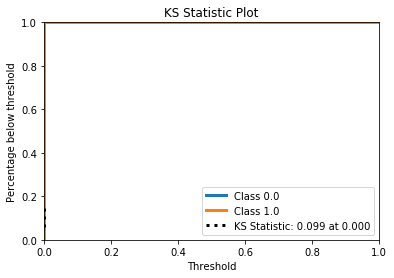

In [37]:
skplt.metrics.plot_ks_statistic(np.squeeze(target_y),
                                probs )
plt.show()

In [89]:
import h2o
from h2o.estimators import H2OXGBoostEstimator
h2o.init(nthreads = 10 )

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,23 secs
H2O cluster timezone:,Asia/Seoul
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.2
H2O cluster version age:,10 months and 26 days !!!
H2O cluster name:,H2O_from_python_root_cckef0
H2O cluster total nodes:,1
H2O cluster free memory:,26.62 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,10
H2O cluster status:,"locked, healthy"


In [90]:
h2o.remove_all()
h2o.ls()

,key


In [91]:
h2o_data = h2o.H2OFrame(data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [92]:
h2o_y = h2o.H2OFrame(target_y)
h2o_y = h2o_y.asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [96]:
df = h2o_data.cbind(h2o_y)
train, valid = df.split_frame(seed = 1234, 
                             destination_frames=["train.hex", "test.hex"])
xgb = H2OXGBoostEstimator(max_depth = 7 , ntrees = 300 , 
                          colsample_bytree = 0.9 , learn_rate= 0.001 , 
                          gamma = 0.0 , sample_rate = 1.0 , 
                          stopping_rounds = 50, stopping_tolerance = 0.001, 
                          stopping_metric = "AUC", 
                         )

In [97]:
# http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/_modules/h2o/estimators/xgboost.html
# https://github.com/h2oai/h2o-tutorials/blob/master/best-practices/categorical-predictors/gbm_drf.ipynb
# https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e

In [98]:
xgb.train(x= h2o_data.col_names ,
          y = h2o_y.col_names[0] ,
          training_frame= train ,
          validation_frame = valid ,
         )

xgboost Model Build progress: |███████████████████████████████████████████| 100%


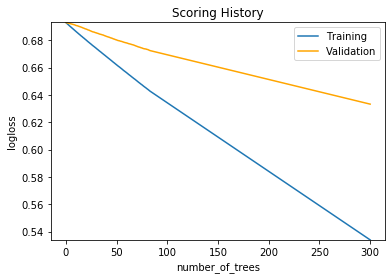

In [99]:
xgb.plot()

In [100]:
xgb.model_performance(train = True )


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17137135004997153
RMSE: 0.4139702284584865
LogLoss: 0.5339180751316165
Mean Per-Class Error: 0.0036231884057971175
AUC: 0.999860646599777
pr_auc: 0.9804028971753935
Gini: 0.999721293199554
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4584940969944: 


,0,1,Error,Rate
0,137.0,1.0,0.0072,(1.0/138.0)
1,0.0,52.0,0.0,(0.0/52.0)
Total,137.0,53.0,0.0053,(1.0/190.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4584941,0.9904762,52.0
max f2,0.4584941,0.9961686,52.0
max f0point5,0.4980001,0.9960937,50.0
max accuracy,0.4980001,0.9947368,50.0
max precision,0.6040001,1.0,0.0
max recall,0.4584941,1.0,52.0
max specificity,0.6040001,1.0,0.0
max absolute_mcc,0.4584941,0.9869257,52.0
max min_per_class_accuracy,0.4584941,0.9927536,52.0
max mean_per_class_accuracy,0.4584941,0.9963768,52.0


Gains/Lift Table: Avg response rate: 27.37 %, avg score: 44.29 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0105263,0.5948251,3.6538462,3.6538462,1.0,0.5995193,1.0,0.5995193,0.0384615,0.0384615,265.3846154,265.3846154
,2,0.0210526,0.5919032,3.6538462,3.6538462,1.0,0.5940889,1.0,0.5968041,0.0384615,0.0769231,265.3846154,265.3846154
,3,0.0315789,0.5850073,3.6538462,3.6538462,1.0,0.5884565,1.0,0.5940215,0.0384615,0.1153846,265.3846154,265.3846154
,4,0.0421053,0.5826264,3.6538462,3.6538462,1.0,0.5846617,1.0,0.5916816,0.0384615,0.1538462,265.3846154,265.3846154
,5,0.0526316,0.5770178,3.6538462,3.6538462,1.0,0.5790797,1.0,0.5891612,0.0384615,0.1923077,265.3846154,265.3846154
,6,0.1,0.5706316,3.6538462,3.6538462,1.0,0.5737290,1.0,0.5818512,0.1730769,0.3653846,265.3846154,265.3846154
,7,0.1526316,0.5586152,3.6538462,3.6538462,1.0,0.5661587,1.0,0.5764400,0.1923077,0.5576923,265.3846154,265.3846154
,8,0.2,0.5377676,3.6538462,3.6538462,1.0,0.5486896,1.0,0.5698676,0.1730769,0.7307692,265.3846154,265.3846154
,9,0.3,0.4426871,2.6923077,3.3333333,0.7368421,0.4964944,0.9122807,0.5454098,0.2692308,1.0,169.2307692,233.3333333
,10,0.4,0.4164131,0.0,2.5,0.0,0.4280768,0.6842105,0.5160766,0.0,1.0,-100.0,150.0


In [101]:
xgb.model_performance(valid = True )


ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.22042639978281522
RMSE: 0.4694958996443049
LogLoss: 0.6333331148000774
Mean Per-Class Error: 0.38888888888888884
AUC: 0.5629629629629629
pr_auc: 0.3040824550798613
Gini: 0.12592592592592577
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3959825038909912: 


,0,1,Error,Rate
0,13.0,32.0,0.7111,(32.0/45.0)
1,1.0,14.0,0.0667,(1.0/15.0)
Total,14.0,46.0,0.55,(33.0/60.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3959825,0.4590164,45.0
max f2,0.3959825,0.6603774,45.0
max f0point5,0.4806994,0.3968254,11.0
max accuracy,0.5112829,0.7666667,2.0
max precision,0.5112829,0.6666667,2.0
max recall,0.3865817,1.0,55.0
max specificity,0.5532895,0.9777778,0.0
max absolute_mcc,0.3959825,0.2275079,45.0
max min_per_class_accuracy,0.4188367,0.5111111,29.0
max mean_per_class_accuracy,0.3959825,0.6111111,45.0


Gains/Lift Table: Avg response rate: 25.00 %, avg score: 43.44 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0166667,0.5427096,0.0,0.0,0.0,0.5532895,0.0,0.5532895,0.0,0.0,-100.0,-100.0
,2,0.0333333,0.5310241,4.0,2.0,1.0,0.5353575,0.5,0.5443235,0.0666667,0.0666667,300.0,100.0
,3,0.0333333,0.5168201,0.0,2.0,0.0,0.0,0.5,0.5443235,0.0,0.0666667,-100.0,100.0
,4,0.05,0.5106337,4.0,2.6666667,1.0,0.5112829,0.6666667,0.5333100,0.0666667,0.1333333,300.0,166.6666667
,5,0.05,0.5095698,0.0,2.6666667,0.0,0.0,0.6666667,0.5333100,0.0,0.1333333,-100.0,166.6666667
,6,0.1,0.4990013,0.0,1.3333333,0.0,0.5041822,0.3333333,0.5187461,0.0,0.1333333,-100.0,33.3333333
,7,0.15,0.4912541,1.3333333,1.3333333,0.3333333,0.4950066,0.3333333,0.5108329,0.0666667,0.2,33.3333333,33.3333333
,8,0.2,0.4777059,2.6666667,1.6666667,0.6666667,0.4868118,0.4166667,0.5048277,0.1333333,0.3333333,166.6666667,66.6666667
,9,0.3,0.4582327,0.0,1.1111111,0.0,0.4667884,0.2777778,0.4921479,0.0,0.3333333,-100.0,11.1111111
,10,0.4,0.4363998,0.6666667,1.0,0.1666667,0.4500237,0.25,0.4816169,0.0666667,0.4,-33.3333333,0.0


In [104]:
xgb._model_json.keys()

dict_keys(['__meta', 'model_id', 'algo', 'algo_full_name', 'response_column_name', 'data_frame', 'timestamp', 'have_pojo', 'have_mojo', 'parameters', 'output', 'compatible_frames'])

In [105]:
xgb._model_json["output"].keys()

dict_keys(['__meta', 'names', 'domains', 'cross_validation_models', 'cross_validation_predictions', 'cross_validation_holdout_predictions_frame_id', 'cross_validation_fold_assignment_frame_id', 'model_category', 'model_summary', 'scoring_history', 'training_metrics', 'validation_metrics', 'cross_validation_metrics', 'cross_validation_metrics_summary', 'status', 'start_time', 'end_time', 'run_time', 'help', 'variable_importances', 'variable_importances_cover', 'variable_importances_frequency', 'native_parameters', 'sparse'])

In [106]:
importances = xgb._model_json["output"]["variable_importances"].as_data_frame()
importances.head()

,variable,relative_importance,scaled_importance,percentage
0,243,7814.436035,1.000000,0.087597
1,29,7449.145996,0.953254,0.083502
2,35,6703.432617,0.857827,0.075143
3,299,6406.179688,0.819788,0.071811
4,219,5972.325684,0.764268,0.066947


In [107]:
importances["variable"] = importances["variable"].astype(object)

In [108]:
select_col = importances[importances["relative_importance"] > 5]["variable"].values.tolist()
print(select_col)

['243', '29', '35', '299', '219', '32', '59', '133', '150', '127', '103', '199', '78', '77', '74', '23', '267', '264', '14', '152', '177', '54', '215', '93', '52', '162', '176', '76', '220', '159', '297', '94', '185', '140', '115', '108', '95', '198', '34', '130', '137', '240', '18', '49', '141', '260', '17', '50', '161', '104', '57', '63', '214', '56', '62', '201', '53', '48', '80', '277', '247', '261', '258', '287', '119', '284', '12', '100', '135', '33', '273', '167', '225', '279', '216', '292', '75', '69', '268', '276', '90', '223', '106', '281', '92', '112', '3', '128', '111', '20', '250', '192', '269', '60', '190', '84', '205', '251', '91', '270', '191', '136', '160', '182', '68', '180', '99', '290', '66', '79', '25', '11', '142', '8', '27', '193', '282', '30', '202', '7', '203', '31', '58', '253', '43', '244', '246', '126', '224', '262', '121', '172', '125', '265', '0']


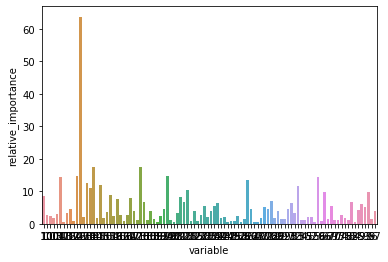

In [105]:
sns.barplot(x = "variable", 
            y="relative_importance", data = importances.head(100))
plt.show()

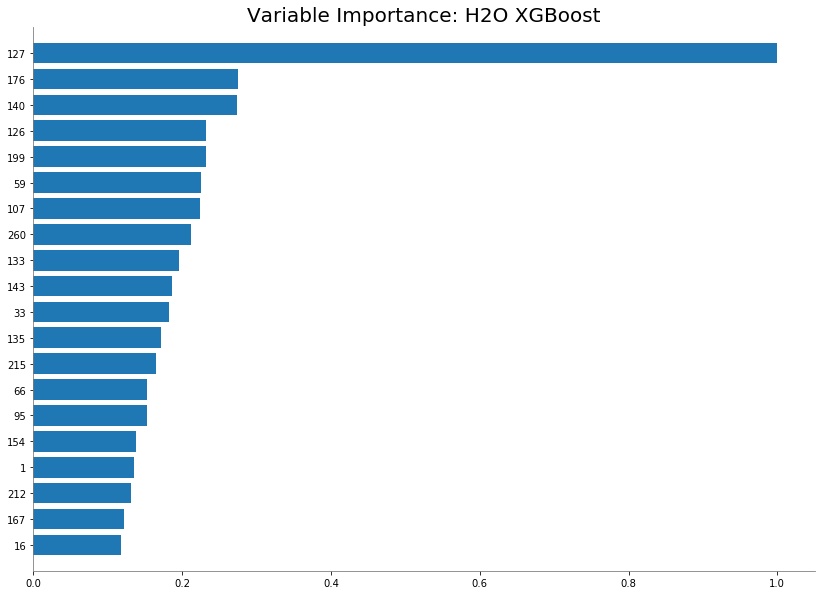

In [107]:
xgb.varimp_plot(num_of_features =20)